In [82]:
from jax import random
import neural_tangents as nt
from neural_tangents import stax
import jax.numpy as np
from jax import grad, jit, vmap
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as onp


In [111]:
@jit
def loss(params, x, y):
    yhat = apply_fn(params, x)
    mse = np.mean(np.square(yhat - y))
    return mse

@jit
def update(params, x, y, lr=0.01):
    grads = grad(loss)(params, x, y)
    params_new = []
    for p, g in zip(params, grads):
        if len(p) == 0: # relu doesn't update
            params_new.append(p)
        else:
            w, b = p
            dw, db = g
            params_new.append((w - lr * dw, b - lr * db))
    return params_new


def get_trained_net(x, y, n_epochs=1000, lr=0.1):
    
    # initialize params
    _, params = init_fn(key3, x.shape)

    # train net
    for epoch in tqdm(range(n_epochs)):
        params = update(params, x, y, lr=lr)
        # print(loss(params, x, y))
        
    return params

In [112]:
# generate data
key1, key2, key3, key4 = random.split(random.PRNGKey(1), 4)
D = 40
N = 1000
noise = 0.1
lr = 0.03
n_epochs = 10000
widths = np.logspace(0, 2.5, num=50)

x_train = random.normal(key1, (N, D))
x_test = random.normal(key2, (N, D))
w = random.normal(key4, (D, 1))
w = w / np.linalg.norm(w)
y_train = x_train @ w + noise * random.normal(key3, (N, 1)) # random.uniform(key1, shape=(3, 1))
y_test = x_test @ w

In [ ]:
# get trained neural net
results = {}
for width in widths:
    width = int(width)
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width), stax.Relu(),
        stax.Dense(width), stax.Relu(),
        stax.Dense(1)
    )
    params = get_trained_net(x_train, y_train, n_epochs=n_epochs, lr=lr)    

    # get ntk kernel
    kernel_fn = nt.empirical_kernel_fn(apply_fn)
    ntk_train_train = kernel_fn(x_train, None, 'ntk', params)
    ntk_test_train = kernel_fn(x_test, x_train, 'ntk', params)

    # predict using ntk
    '''
    mse_predictor = nt.predict.gradient_descent_mse(ntk_train_train, y_train)
    t = 5 # time training with gradient descent
    y_train_0 = apply_fn(params, x_train)
    y_test_0 = apply_fn(params, x_test)
    y_train_t, y_test_t = mse_predictor(t, y_train_0, y_test_0, ntk_test_train)
    print('mse', np.mean(np.square(y_test_t - y_test)))
    '''

    # calculate mdl-comp + more
    r = {
        'mse_norms': [],
        'theta_norms': [],
        'eigensums': [],
        'mdl_comps': [],
        'mse_tests': [],
    } 
    reg_params = np.logspace(-3, 3, num=10)
    for l in tqdm(reg_params):
        inv = np.linalg.pinv(ntk_train_train + l * np.eye(ntk_train_train.shape[0]))
        eigenvals, eigenvecs = np.linalg.eig(ntk_train_train)
        # inv = pkl.load(open(oj(out_dir, f'invs/pinv_mot_energy_kernel_ntk_{l}.pkl'), 'rb'))
        thetahat = inv @ y_train
        mse_norm = np.linalg.norm(ntk_train_train @ thetahat - y_train)**2 / (2 * noise)
        theta_norm = thetahat.T @ ntk_train_train @ thetahat / (2 * noise)
        eigensum = 0.5 * np.sum(np.log(1 + eigenvals / l))
        mdl_comp = (mse_norm + theta_norm + eigensum) / N
        mse_test_mdl = np.mean(np.square(y_test - ntk_test_train @ thetahat))

        r['mse_norms'].append(mse_norm)
        r['theta_norms'].append(theta_norm)
        r['eigensums'].append(eigensum)
        r['mdl_comps'].append(mdl_comp)
        r['mse_tests'].append(mse_test_mdl)
    results[width] = r

In [114]:
pkl.dump(results, open('../data/intermediate/empirical_ntk_results_ext.pkl', 'wb'))

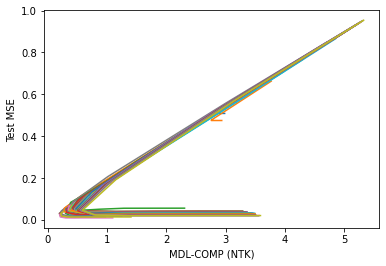

In [115]:
for k in sorted(results.keys()):
    plt.plot([x.flatten() for x in results[k]['mdl_comps']],
             results[k]['mse_tests'])
    plt.xlabel('MDL-COMP (NTK)')
    plt.ylabel('Test MSE')
plt.show()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 18, 21, 23, 26, 30, 33, 38, 42, 48, 54, 61, 68, 77, 86, 97, 109, 123, 138, 156, 175, 197, 222, 250, 281, 316])


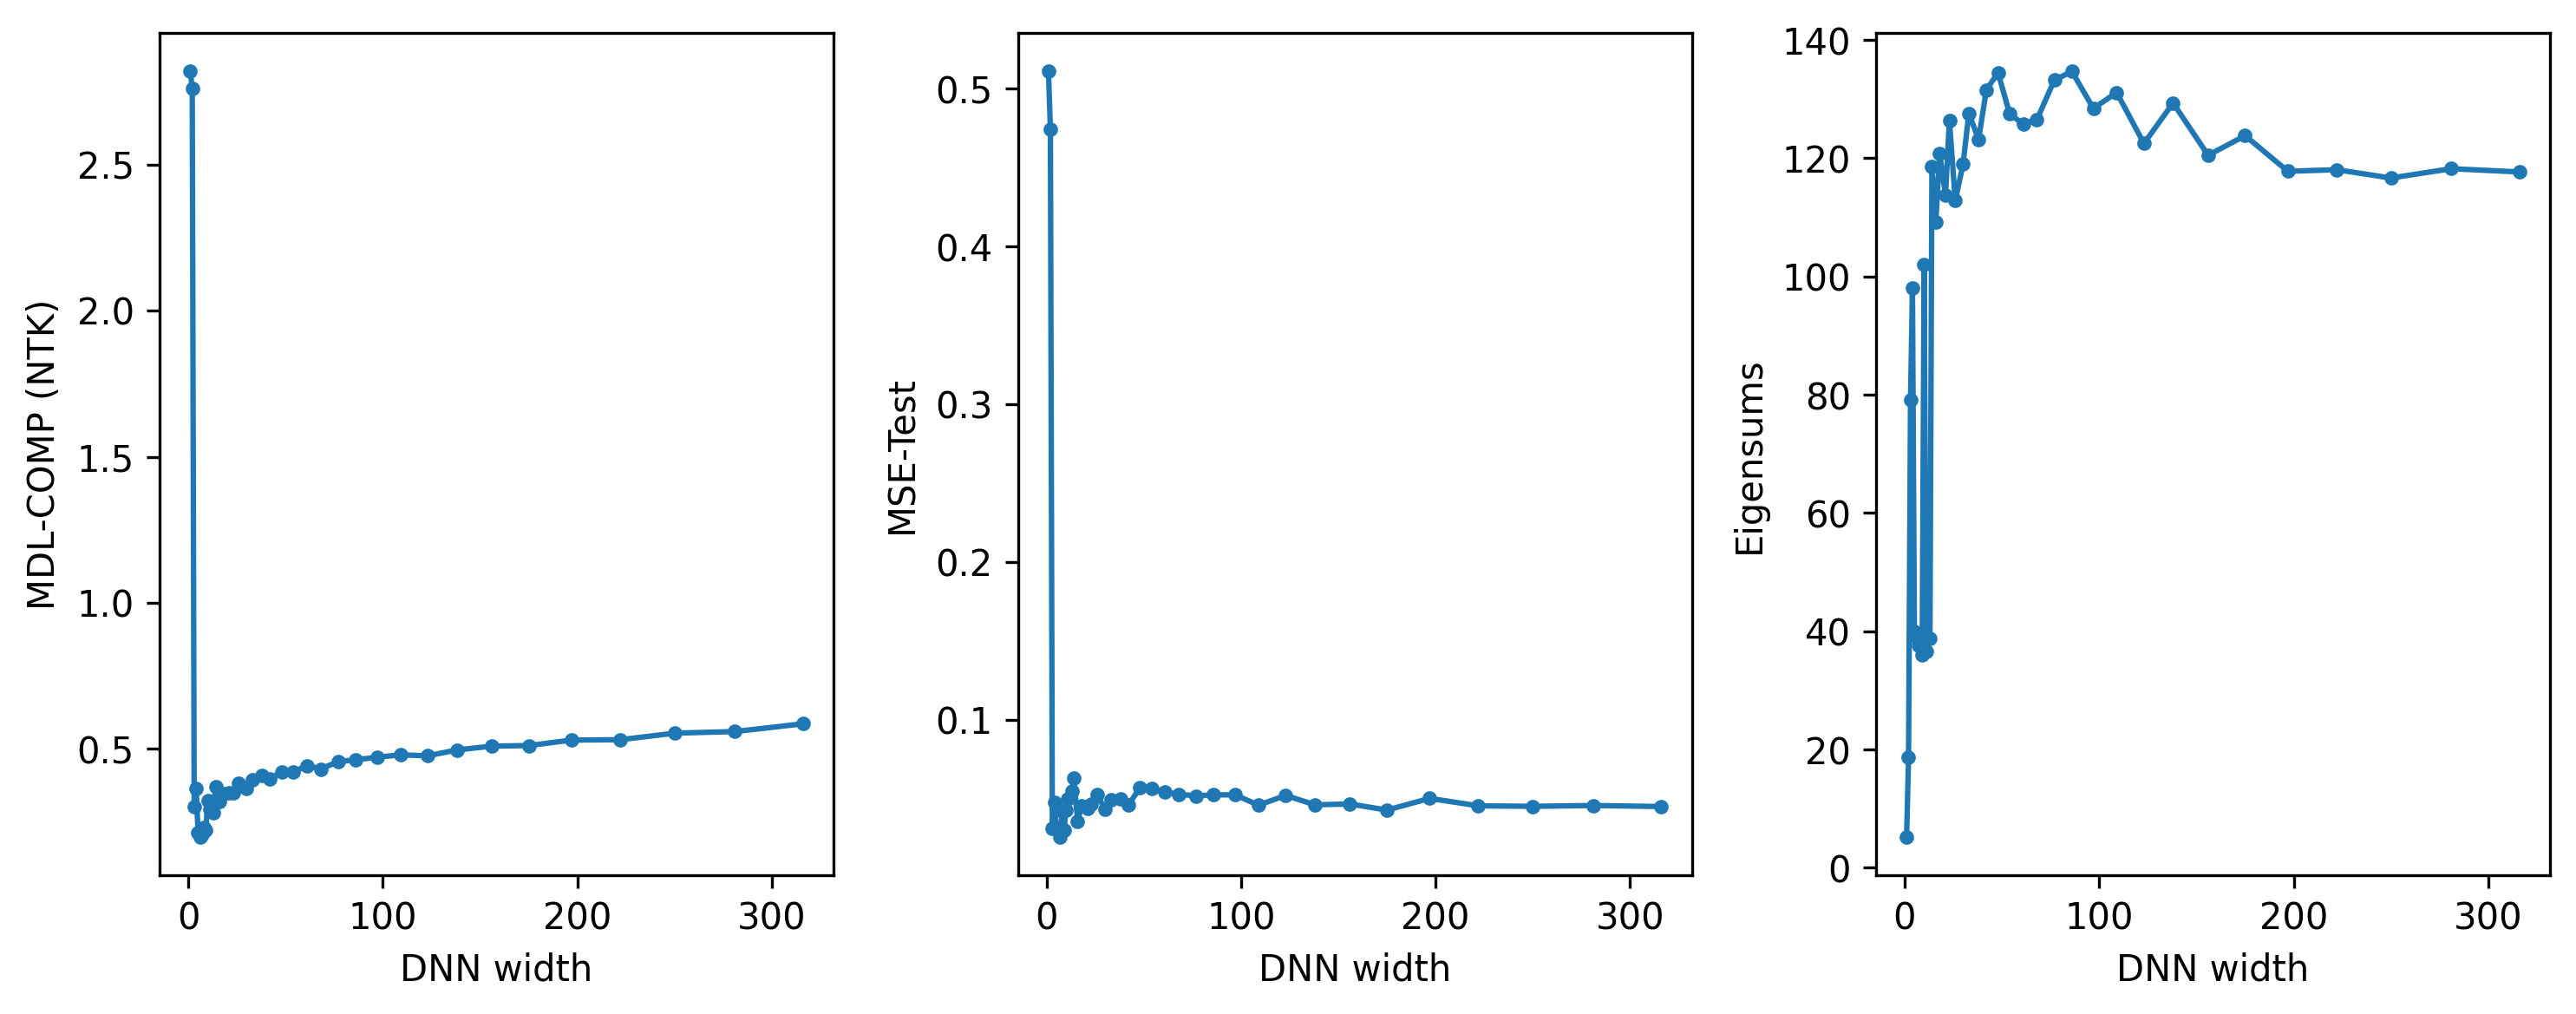

In [120]:
mdls = []
mses = []
eigensums = []
print(results.keys())
for k in sorted(results.keys()):
    mdls.append(np.min(np.array(results[k]['mdl_comps'])))
    argmin = onp.argmin(onp.array(results[k]['mdl_comps']))
    mses.append(results[k]['mse_tests'][argmin])
    eigensums.append(results[k]['eigensums'][argmin])
#     mses.append(np.min(np.array(results[k]['mse_tests'])))
    
R, C = 1, 3
plt.figure(figsize=(10, 4), dpi=300, facecolor='w')
plt.subplot(R, C, 1)
plt.plot(sorted(results.keys()), mdls, '.-')
# plt.xscale('log')
plt.xlabel('DNN width')
plt.ylabel('MDL-COMP (NTK)')

plt.subplot(R, C, 2)
plt.plot(sorted(results.keys()), mses, '.-')
# plt.xscale('log')
plt.xlabel('DNN width')
plt.ylabel('MSE-Test')

plt.subplot(R, C, 3)
plt.plot(sorted(results.keys()), eigensums, '.-')
# plt.xscale('log')
plt.xlabel('DNN width')
plt.ylabel('Eigensums')
plt.tight_layout()
plt.show()

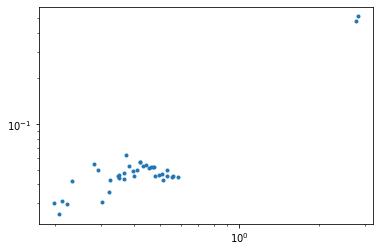

In [117]:
plt.plot(mdls, mses, '.')
plt.xscale('log')
plt.yscale('log')